#REGRESSION
## SVM & GP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import random 
from scipy.optimize import curve_fit

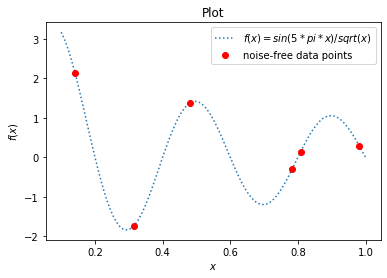

In [ ]:
#function
def func(data):
    return (np.sin(5*data*np.pi)/np.sqrt(data))

#number of data points
n = 6
m=100

#define interval 
a = 0.1
b = 1

#generate random data grid
x = []
for i in range(0, n):
    x.append(random.uniform(a, b))
#x.sort()
#print(x)
x_array = np.array(x)

#noise-free data points
yclean = []
for i in range(0, n):
    yclean.append(func(x[i]))
#print(yclean)
yclean_array = np.array(yclean)
#data to draw the real concept 
x_rc = []
for i in range(0, n):
    x_rc.append(random.uniform(a, b))
#x.sort()
#print(x)


#now x and y is your data 
#define analytic x and y
x_rc = np.linspace(a, b, m)
y_rc = []
for i in range(0, m):
    y_rc.append(func(x_rc[i]))

#plt.scatter(x_rc, y_rc)
#plt.scatter(x, yclean, c='red')

plt.plot(x_rc, y_rc, label=r"$f(x) = sin(5*pi*x)/sqrt(x)$", linestyle="dotted")
plt.plot(x, yclean, label=r"noise-free data points", c='red', marker='o', linewidth=0)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Plot")

## SVM regression - NOISE FREE DATASET

In [ ]:
from sklearn import svm

In [ ]:
regr = svm.SVR(kernel='rbf', C=1).fit(x_array.reshape(-1,1), yclean_array.reshape(-1,1))
svm_pred=regr.predict(x_rc.reshape(-1,1))
#print(svm_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## GAUSSIAN PROCESS - NOISE FREE DATASET

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [ ]:
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))


gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(x_array.reshape(-1,1), yclean_array.reshape(-1,1))
#if None is passed, the kernel ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed") is used as default. 
print(gpr.kernel_)

#mean, stdv = gpr.predict(x_array.reshape(-1,1), return_std=True)
#print('y mean', mean)
#print('standard deviation', stdv)
#resul.y_mean

1.33**2 * RBF(length_scale=0.0575)


##### After fitting our model, we see that the hyperparameters of the kernel have been optimized. Now, we will use our kernel to compute the mean prediction of the full dataset and plot the 95% confidence interval.

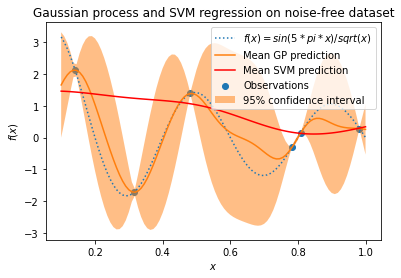

In [ ]:
mean_prediction, std_prediction = gpr.predict(x_rc.reshape(-1,1), return_std=True)
#print(std_prediction.ravel())
plt.plot(x_rc, y_rc, label=r"$f(x) = sin(5*pi*x)/sqrt(x)$", linestyle="dotted")
plt.scatter(x_array, yclean_array, label="Observations")
plt.plot(x_rc, mean_prediction, label="Mean GP prediction")
plt.plot(x_rc,svm_pred, label="Mean SVM prediction", c='red')

plt.fill_between(
    x_rc.ravel(),
    mean_prediction.ravel() - 1.96* std_prediction.ravel(),
    mean_prediction.ravel() + 1.96 * std_prediction.ravel(),
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process and SVM regression on noise-free dataset")

##### We should see (for the gaussian process) that for a prediction made on a data point close to the one from the training set, the 95% confidence has a small amplitude. Whenever a sample falls far from training data, our model’s prediction is less accurate and the model prediction is less precise (higher uncertainty).

##  NOISY DATASET

In [ ]:
#from numpy import random
#random = np.random.RandomState(1)
#noise_std = 0.10
#ynoisy_array = np.array(ynoisy)
#ynoisy_array = yclean_array + random.normal(loc=0.0, scale=noise_std, size=yclean_array.shape)


In [ ]:
mu0 = 0 
sigma0 = 0.3

noise = st.norm.rvs(mu0, sigma0, size = n)
ynoisy = yclean + noise
ynoisy_array = np.array(ynoisy)

## SVM - NOISY DATASET

In [ ]:
regr_noisy = svm.SVR(kernel='rbf', C=1).fit(x_array.reshape(-1,1), ynoisy_array.reshape(-1,1))
svm_pred_noisy=regr_noisy.predict(x_rc.reshape(-1,1))
#print(svm_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## GAUSSIAN PROCESS - NOISY DATASET

In [ ]:
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=sigma0**2, n_restarts_optimizer=9  #noise_std
)
#ALPHA: Value added to the diagonal of the kernel matrix during fitting. This can prevent a potential numerical issue during fitting, by ensuring that the calculated values form a positive definite matrix. It can also be interpreted as the variance of additional Gaussian measurement noise on the training observations. 
gaussian_process.fit(x_array.reshape(-1,1), ynoisy_array.reshape(-1,1))
mean_prediction, std_prediction = gaussian_process.predict(x_rc.reshape(-1,1), return_std=True)

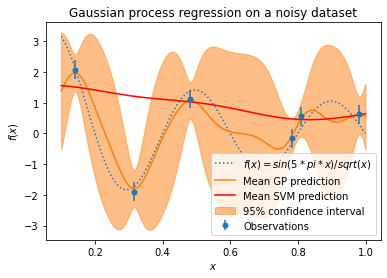

In [ ]:
plt.plot(x_rc, y_rc, label=r"$f(x) = sin(5*pi*x)/sqrt(x)$", linestyle="dotted")
plt.errorbar(
    x_array.ravel(),
    ynoisy_array.ravel(),
    sigma0, #noise_std
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(x_rc, mean_prediction, label="Mean GP prediction")
plt.plot(x_rc, svm_pred_noisy, label="Mean SVM prediction", c='red')
plt.fill_between(
    x_rc.ravel(),
    mean_prediction.ravel() - 1.96 * std_prediction.ravel(),
    mean_prediction.ravel() + 1.96 * std_prediction.ravel(),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")